In [1]:
import warnings
warnings.filterwarnings("ignore")
# Augmenter la densité de pixel
import matplotlib as mpl
import scipy.stats as scpstats
mpl.rcParams['figure.dpi'] = 100
from croscor import *
import csv
import os
band1 = np.load("../data/band1.npy")
band2 = np.load("../data/band2.npy")

#

In [2]:
b1,b2 = shiftSelec(band1,band2,0,0)

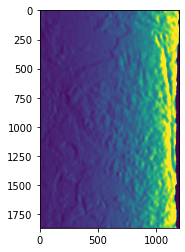

In [3]:
plt.imshow(band1,vmin = 0, vmax = 5)

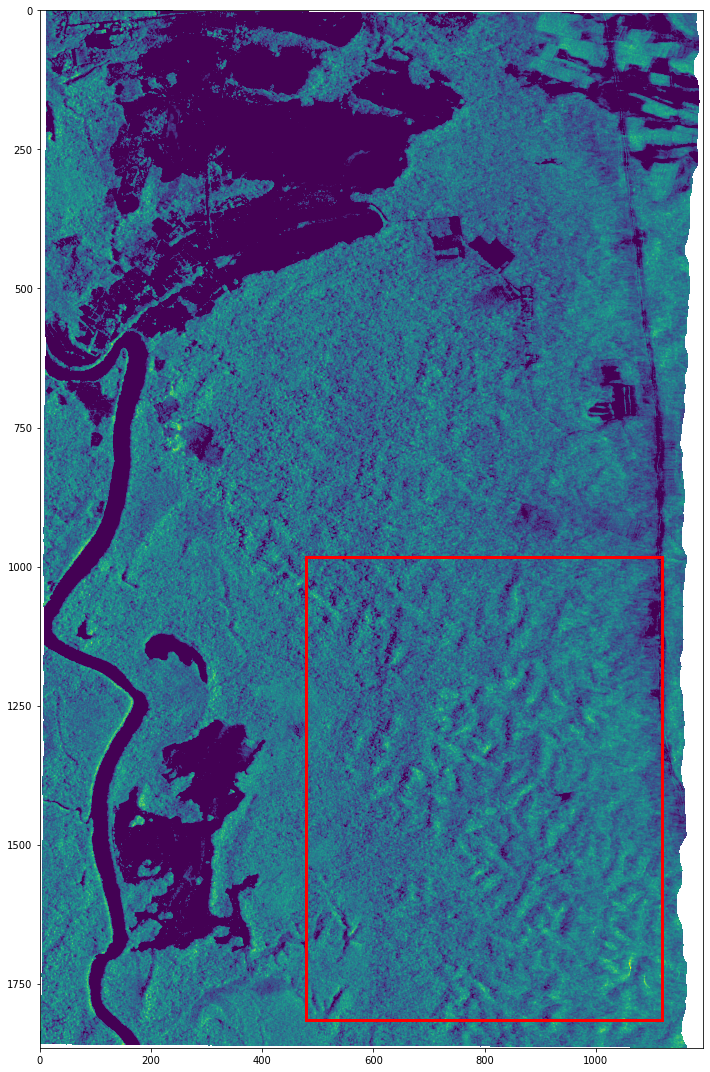

In [13]:
def printRroi():
    margin = 64
    (x0,x1,y0,y1) = (30 + 2 * 256 - margin, 1054 + margin, 215 + 3 * 256, 1751 + margin)
    coord = (x0,x1,y0,y1)
    zone = selection(band2/band1,coord,True)
printRroi()

In [24]:
p = loadParcels(16)[0]
#print(p)
print(np.max(p[:,0]) - np.min(p[:,0]))
print(np.max(p[:,1]) - np.min(p[:,1]))
print(np.mean(p[:,0]))
print(np.mean(p[:,1]))
filename = "../decoup/8f_256bs_15sx_6sy_10seuil_99accu.npy"
tab = np.load(filename)
ff = ExtractFeatures(filename)

# indice dans le tab = i * ncol + j

51
51
662.918648310388
1369.624530663329


In [ ]:
x0 = np.min(p[:,0]) - (np.max(p[:,0]) - np.min(p[:,0]))
x1 = np.max(p[:,0]) + (np.max(p[:,0]) - np.min(p[:,0]))
y0 = np.min(p[:,1]) - (np.max(p[:,1]) - np.min(p[:,1]))
y1 = np.max(p[:,1]) + (np.max(p[:,1]) - np.min(p[:,1]))

coord_zone = x0, y0, x1, y1


In [ ]:
"""
On a l'indice de vecteur donc le numéro de bloc
numéro de bloc vers coordonnées du bloc avec block size, taille de l'image, facteur de recouvrement
coord du bloc vers milieu du bloc avec bloc size
"""

In [16]:

"""
Vérifier qu'on trouve quelque chose de très proche de 0 après déplacement en refaisant un tour
ok
"""
def multichoice():
    ok = True
    choices = []
    while ok:
        choices.append(choice())
        print('\n #######')
        print("Choices :",choices)
        print('\n #######')
        cin = input('Press Enter to continue or type no')
        if cin == 'no':
            ok = False
    return choices

def versus(img1,img2):
    
    fig,ax = plt.subplots(1,2, figsize=(15,8))
    im1 = ax[0].imshow(10*np.log(img1),vmin=-40,vmax=0)
    ax[0].set_title("BAND 1 - original")
    fig.colorbar(im1,ax=ax[0])

    im2 = ax[1].imshow(10*np.log(img2),vmin=-40,vmax=0)
    ax[1].set_title("BAND 1 - déplacement")
    fig.colorbar(im2,ax=ax[1])

    plt.tight_layout()
    plt.show()

def apply_displacement(band1,coord,choices):
    img = np.copy(band1)
    (x0,x1,y0,y1) = coord
    imgs = []
    for tabname in choices:  
        features = ExtractFeatures(tabname)
        print(features["ax0"],features["ax1"])
        img = np.roll(np.roll(band1,- int(features["ax0"]),axis=0),- int(features["ax1"]),axis=1)
        tab = np.load(tabname)
        xm = np.mean(tab[0])
        ym = np.mean(tab[1])
        #print((xm,ym))
        img_new = np.roll(np.roll(img, - int(ym),axis=0), int(xm),axis=1)
        imgs.append(img_new)
    imgs.append(band1)
    return imgs#, selection(img_new,coord)

def apply_displacement2(band1,coord,tabname,parcel):
    img = np.copy(band1)
    (x0,x1,y0,y1) = coord
    imgs = []
    features = ExtractFeatures(tabname)
    print(features["ax0"],features["ax1"])
    ## On applique le shift initial correctif
    img = np.roll(np.roll(band1,- int(features["ax0"]),axis=0),- int(features["ax1"]),axis=1)
    tab = np.load(tabname)
    xm = np.mean(tab[0])
    ym = np.mean(tab[1])
    #print((xm,ym))
    img_new = np.roll(np.roll(img, - int(ym),axis=0), int(xm),axis=1)
    imgs.append(img_new)
    imgs.append(band1)
    return imgs#, selection(img_new,coord)


def pltBiomass2(imgs, choices,num,output = False): #img est l'image corrigée - rapport band2/band1-corrigee
    BiomassData = loadBiomass(num)
    band1 = np.load("../data/band1.npy")
    band2 = np.load("../data/band2.npy")
    pearsonr = []
    Parcels = loadParcels(num)
    plt.figure(1, figsize=(10,5))
    i = 0
    for tabname in choices:
        IntensityData = []
        for X in Parcels:
            img = apply_displacement2(band1,coord,tabname,X)
            
            IntensityZone_X = IntensityZone(X,band2/img)
            IntensityData.append(IntensityZone_X[0])

        sortedData = sortBiomInt(BiomassData,IntensityData)
        if output : 
            print(sortedData)
            print("---------------------------------------------")

        pearsonr.append(scpstats.pearsonr(sortedData[:,0],sortedData[:,1]))
        if i < len(choices):
            features = ExtractFeatures(choices[i])
            label = features
        else:
            label = "ref"
        plt.scatter(sortedData[:,0],sortedData[:,1], label = label)
        i += 1
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.ylim((-30,-10))
    plt.title("Intensité image en fonction de la biomasse sur 16 ROI de forêt")
    plt.xlabel("Qté de biomasse de 16 parcelles (Ordre croissant de qté)")
    plt.xlim((200,500))
    plt.ylabel("Intensité image parcelle")
    plt.savefig("../results/plotMaternelle1.png")
    plt.show()
    
    return pearsonr
    
    
def pltBiomass(imgs, choices,num,output = False): #img est l'image corrigée - rapport band2/band1-corrigee
    BiomassData = loadBiomass(num)
    band1 = np.load("../data/band1.npy")
    band2 = np.load("../data/band2.npy")
    pearsonr = []
    Parcels = loadParcels(num)
    plt.figure(1, figsize=(7,5))
    plt.grid()
    i = 0
    for img in imgs:
        IntensityData = []
        for X in Parcels:
            IntensityZone_X = IntensityZone(X,band2/img)
            #IntensityZone_X = IntensityZone(X,band2/img)
            IntensityData.append(IntensityZone_X[0])

        sortedData = sortBiomInt(BiomassData,IntensityData)
        x = sortedData[:,0]
        y = sortedData[:,1]
        if output : 
            print(sortedData)
            print("---------------------------------------------")
        
        pearsonr.append(scpstats.pearsonr(x,y))
        m, b = np.polyfit(x,y,1)
        

        if i < len(choices):
            features = ExtractFeatures(choices[i])
            label = "Optimized matching | r = %.2f " % (pearsonr[-1][0])
            marker = 'x'
            alpha = 1
            c = 'b'
        else:
            label = "Initial Matching | r = %.2f " % (pearsonr[-1][0])
            marker = 'o'
            alpha = 0.5
            c = 'r'
            
        plt.plot(np.log10(x),m*x + b, linewidth=2, ls="--", c = c, alpha = alpha)
        plt.scatter(np.log10(x),y, label = label, marker=marker, alpha=alpha, c =c)
        print(f'ecart type : {np.std(y)}')
        i += 1
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.ylim((-15,-5))
    plt.grid()
    plt.title("Backscatter intensity (dB) in terms of AGB (log10) for "+str(num)+" ROI",  fontsize=14)
    plt.xlabel("AGB in log10(t/ha)",  fontsize=12)
    #plt.xlim((200,500))
    plt.ylabel("Backscatter intensity in dB",  fontsize=12)
    plt.tight_layout()
    plt.savefig("../results/plotMaternelle1"+str(num))
    plt.show()
    
    return pearsonr
    
def main(num):
    #(x0,x1,y0,y1) = (30 + 2 * 256, 1054, 215 + 3 * 256, 1751)
    #coord = (x0,x1,y0,y1)
    margin = 64
    (x0,x1,y0,y1) = (30 + 2 * 256 - margin, 1054 + margin, 215 + 3 * 256, 1751 + margin)
    coord = (x0,x1,y0,y1)
    choices = choice()
    imgs = apply_displacement(band1,coord,choices)
    #fig, ax = plt.subplots(figsize=(10,15)) 

    #zone = selection(10*np.log(band2/imgs[0]),coord,False)
    #ax.imshow(10*np.log(band2/imgs[0]), vmin=-40,vmax=0)
    #ax.imshow(zone)
    #ax.imshow(10*np.log(band2/imgs[-1]))
    #plt.tight_layout()
    #plt.savefig("../misc/before")
    
    #plt.show()
    pearson = pltBiomass(imgs,choices,num,False)
    print("\n---------------------------------------------")

    print("\n \n Coefs de pearson :")
    wanted_keys = ['ax0', 'ax1', 'f'] # The keys you want
    for i in range(len(choices)):
        features = ExtractFeatures(choices[i])
        features_list = [(k,features[k]) for k in wanted_keys]
        print(features_list,pearson[i])
        #print(features[, pearson[i])
    print('ref', pearson[-1])
    #pearsonr = plotBiomasse(b1_new)
    #np.save('../decoup/band1_new.npy',b1_new)
    #versus(band2/b1_new,band2/band1)
    return imgs[-1]

Liste des résulats disponibles 

0 - 2f_128bs_-9sx_-7sy_10seuil_100accu.npy
1 - 2f_128bs_-5sx_-5sy_10seuil_100accu.npy
2 - 2f_128bs_0sx_0sy_10seuil_100accu.npy
3 - 2f_128bs_-13sx_-9sy_10seuil_100accu.npy
4 - 2f_128bs_-13sx_-10sy_10seuil_55accu.npy
5 - 2f_128bs_-9sx_-7sy_10seuil_55accu.npy
6 - 2f_128bs_0sx_0sy_10seuil_55accu.npy
7 - 2f_128bs_-16sx_-13sy_10seuil_0accu.npy
8 - 2f_128bs_-15sx_-12sy_10seuil_0accu.npy
9 - 2f_256bs_-15sx_-8sy_10seuil_100accu.npy
10 - 2f_256bs_-10sx_-8sy_10seuil_100accu.npy
11 - 2f_256bs_0sx_0sy_10seuil_0accu.npy
12 - 2f_256bs_-14sx_-8sy_10seuil_100accu.npy
13 - zone_foret_old
14 - band1_new.npy
15 - image_totale
16 - samedi
17 - 20f_256bs_15sx_15sy_10seuil_89accu.npy
18 - *2f_256bs_15sx_15sy_10seuil_54accu.npy
19 - 2f_256bs_15sx_15sy_10seuil_66accu.npy
20 - 2f_256bs_15sx_15sy_10seuil_79accu.npy
21 - 2f_256bs_15sx_15sy_10seuil_80accu.npy
22 - 2f_256bs_15sx_15sy_10seuil_95accu.npy
23 - 3f_256bs_15sx_15sy_10seuil_100accu.npy
24 - 3f_256bs_15sx_15sy_10seuil_91acc

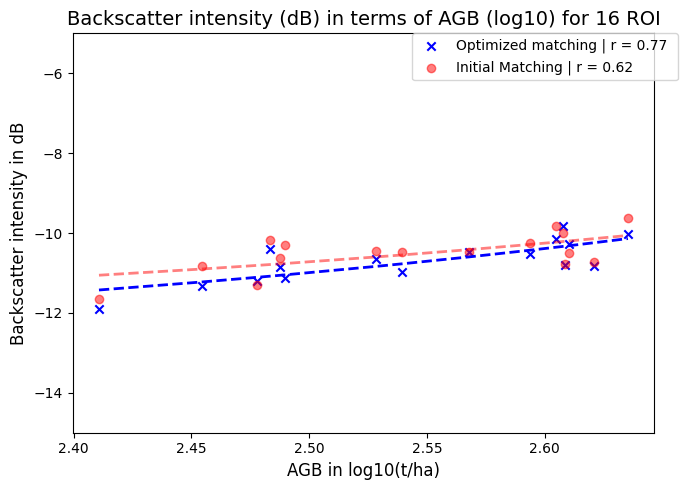


---------------------------------------------

 
 Coefs de pearson :
[('ax0', '15'), ('ax1', '6'), ('f', '8')] (0.768566041682162, 0.0005040793887875772)
ref (0.6200942242169901, 0.010392037672546423)


In [17]:
i = main(16)

Liste des résulats disponibles 

0 - 2f_128bs_-9sx_-7sy_10seuil_100accu.npy
1 - 2f_128bs_-5sx_-5sy_10seuil_100accu.npy
2 - 2f_128bs_0sx_0sy_10seuil_100accu.npy
3 - 2f_128bs_-13sx_-9sy_10seuil_100accu.npy
4 - 2f_128bs_-13sx_-10sy_10seuil_55accu.npy
5 - 2f_128bs_-9sx_-7sy_10seuil_55accu.npy
6 - 2f_128bs_0sx_0sy_10seuil_55accu.npy
7 - 2f_128bs_-16sx_-13sy_10seuil_0accu.npy
8 - 2f_128bs_-15sx_-12sy_10seuil_0accu.npy
9 - 2f_256bs_-15sx_-8sy_10seuil_100accu.npy
10 - 2f_256bs_-10sx_-8sy_10seuil_100accu.npy
11 - 2f_256bs_0sx_0sy_10seuil_0accu.npy
12 - 2f_256bs_-14sx_-8sy_10seuil_100accu.npy
13 - zone_foret_old
14 - band1_new.npy
15 - image_totale
16 - samedi
17 - 20f_256bs_15sx_15sy_10seuil_89accu.npy
18 - *2f_256bs_15sx_15sy_10seuil_54accu.npy
19 - 2f_256bs_15sx_15sy_10seuil_66accu.npy
20 - 2f_256bs_15sx_15sy_10seuil_79accu.npy
21 - 2f_256bs_15sx_15sy_10seuil_80accu.npy
22 - 2f_256bs_15sx_15sy_10seuil_95accu.npy
23 - 3f_256bs_15sx_15sy_10seuil_100accu.npy
24 - 3f_256bs_15sx_15sy_10seuil_91acc

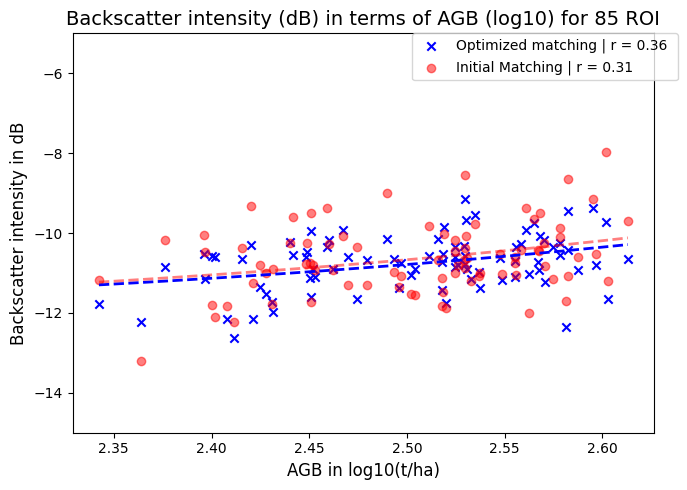


---------------------------------------------

 
 Coefs de pearson :
[('ax0', '15'), ('ax1', '6'), ('f', '8')] (0.3556913438327623, 0.0008356192986918368)
ref (0.3075586346069711, 0.0041923115686764425)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
main(85)

Liste des résulats disponibles 

0 - 2f_256bs_-15sx_-8sy_10seuil_100accu.npy
1 - 2f_256bs_-10sx_-8sy_10seuil_100accu.npy
2 - 2f_256bs_0sx_0sy_10seuil_0accu.npy
3 - 2f_256bs_-14sx_-8sy_10seuil_100accu.npy
4 - zone_foret_old
5 - band1_new.npy
6 - image_totale
7 - samedi
8 - 20f_256bs_15sx_15sy_10seuil_89accu.npy
9 - *2f_256bs_15sx_15sy_10seuil_54accu.npy
10 - 2f_256bs_15sx_15sy_10seuil_66accu.npy
11 - 2f_256bs_15sx_15sy_10seuil_79accu.npy
12 - 2f_256bs_15sx_15sy_10seuil_80accu.npy
13 - 2f_256bs_15sx_15sy_10seuil_95accu.npy
14 - 3f_256bs_15sx_15sy_10seuil_100accu.npy
15 - 3f_256bs_15sx_15sy_10seuil_91accu.npy
16 - 3f_256bs_15sx_15sy_10seuil_95accu.npy
17 - 4f_256bs_15sx_15sy_10seuil_83accu.npy
18 - 4f_256bs_15sx_15sy_10seuil_88accu.npy
19 - 4f_256bs_15sx_15sy_10seuil_91accu.npy
20 - 8f_256bs_0sx_0sy_10seuil_0accu.npy
21 - 8f_256bs_15sx_15sy_10seuil_89accu.npy
22 - 8f_256bs_15sx_6sy_10seuil_99accu.npy

 ## Pour mettre fin à la sélection, appuyer sur entré sans entrer de numéro ##

Selectio

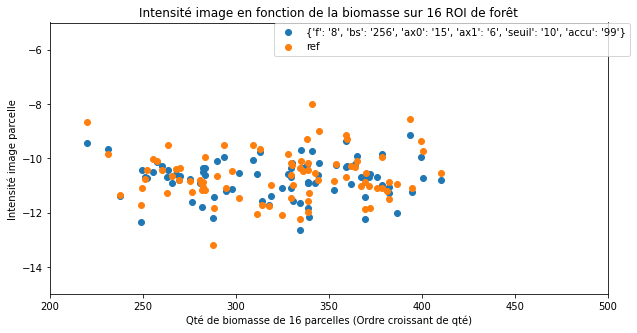


---------------------------------------------

 
 Coefs de pearson :
[('ax0', '15'), ('ax1', '6'), ('f', '8')] (-0.020341684954389403, 0.8533989581959261)
ref (0.05887376277510037, 0.5924997179327312)


In [19]:
main(85)

In [ ]:
"""
db en ordonnée
corrélation en fonction du log10 de la biomasse
Appliquer à toute une image (déplacement élastique)
"""

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


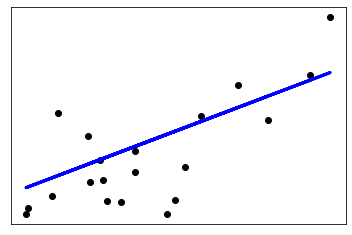

In [6]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
regr.predict(diabetes_X_test)

In [ ]:
diabetes_y_pred = regr.predict(diabetes_X_test)